# TinyML Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.signal import butter, lfilter, freqz

## Filter implementations for testing different settings

In [2]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Settings for filter tests
cutoff = 1
fs = 3000
order = 6

## Example data file

In [3]:
DATA_FILE = "../flight-sample-data/full-data/IMU/flight0.csv"

data = pd.read_csv(DATA_FILE)
data

,timestamp,acc_x,acc_y,acc_z,rot_x,rot_y,rot_z,qfe,temp,phase
0,431,0.10,0.09,0.94,0.18,1.95,1.71,988.69,25.04,pre_take_off
1,469,0.11,0.09,0.97,3.05,3.48,1.34,988.66,25.06,pre_take_off
2,507,0.11,0.09,0.97,1.89,2.99,1.40,988.71,25.08,pre_take_off
3,545,0.11,0.09,0.97,1.89,2.81,1.40,988.71,25.10,pre_take_off
4,583,0.11,0.09,0.97,1.77,2.93,1.46,988.68,25.11,pre_take_off
...,...,...,...,...,...,...,...,...,...,...
252669,10227823,-0.03,0.13,0.98,1.65,3.05,0.98,982.13,25.24,landed
252670,10227862,-0.03,0.13,0.98,1.65,2.75,1.04,982.08,25.24,landed
252671,10227900,-0.03,0.13,0.98,1.77,2.99,1.04,982.12,25.26,landed
252672,10227938,-0.03,0.13,0.98,1.71,3.05,1.04,982.12,25.25,landed


## Plotting data with flight mode labels

In [4]:
def plot_data(df, output_file=None):
    x = df.index
    
    # Center the values around their mean
    df['rot_z_centered'] = df['rot_z'] - df['rot_z'].mean()
    df['qfe_centered'] = df['qfe'] - df['qfe'].mean()

    # Plot centered values
    plt.figure(figsize=(20, 6))
    plt.plot(x, df['rot_z_centered'], label='rot_z')
    plt.plot(x, df['qfe_centered'], label='QFE')
    
    # Create axvspan regions based on label changes
    current_label = None
    start_idx = 0
    
    # Assign each label a unique color
    labels = df['phase'].unique()
    color_map = {label: color for label, color in zip(labels, mcolors.TABLEAU_COLORS)}
    
    for i in range(len(df)):
        if df['phase'].iloc[i] != current_label:
            if current_label is not None:
                plt.axvspan(x[start_idx], x[i-1], color=color_map[current_label], alpha=0.2, label=f"Label: {current_label}")
            current_label = df['phase'].iloc[i]
            start_idx = i
    
    # Add the final segment
    plt.axvspan(x[start_idx], x[-1], color=color_map[current_label], alpha=0.2, label=f"Label: {current_label}")
    
    # Avoid duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.xlabel('Index')
    plt.ylabel('Value (adjusted for easier referencing)')
    plt.title('flight phases based on IMU and barometric pressure data')
    plt.tight_layout()
    
    if output_file is not None:
        plt.savefig(output_file)

    plt.show()

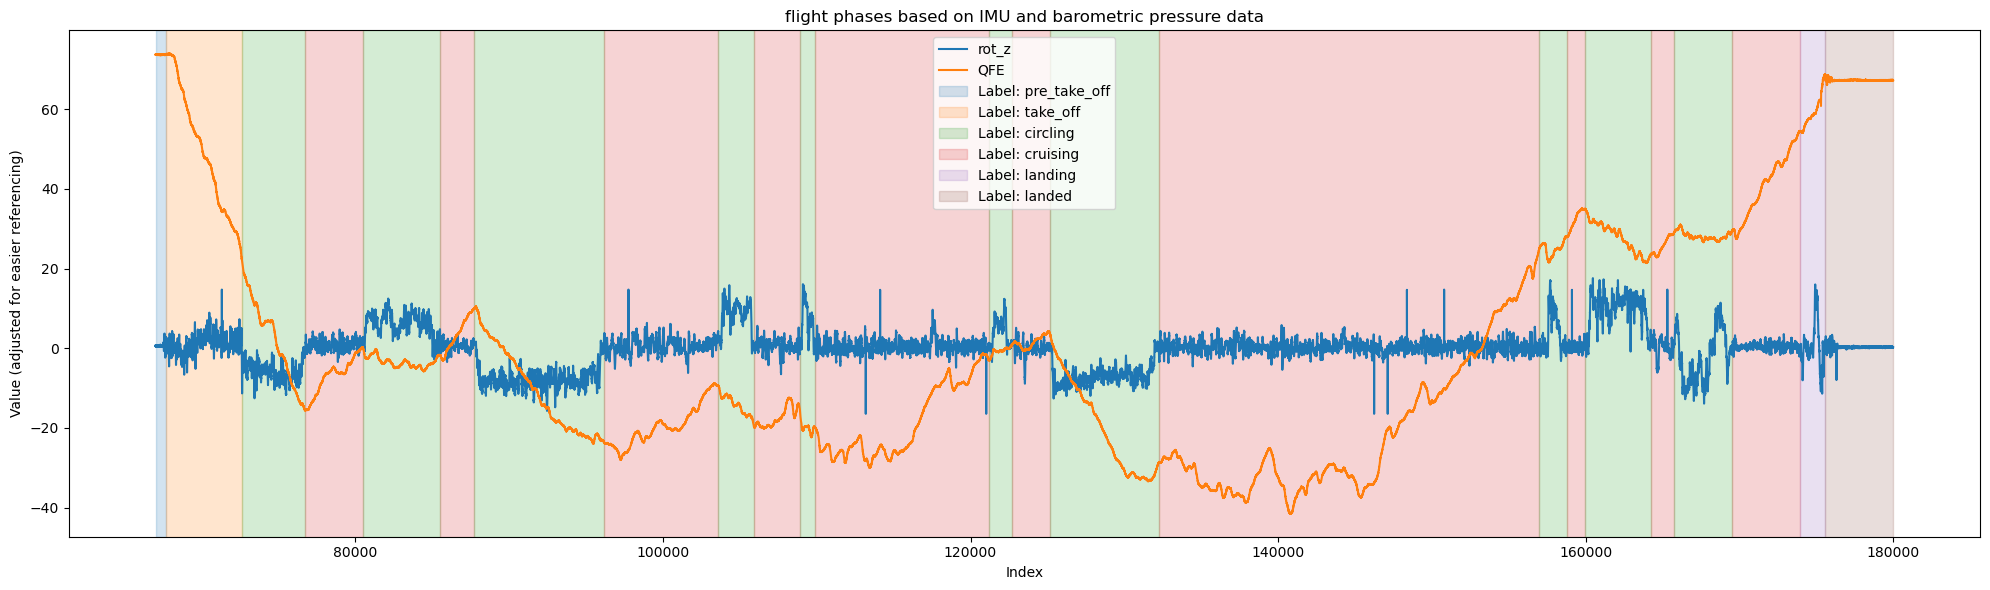

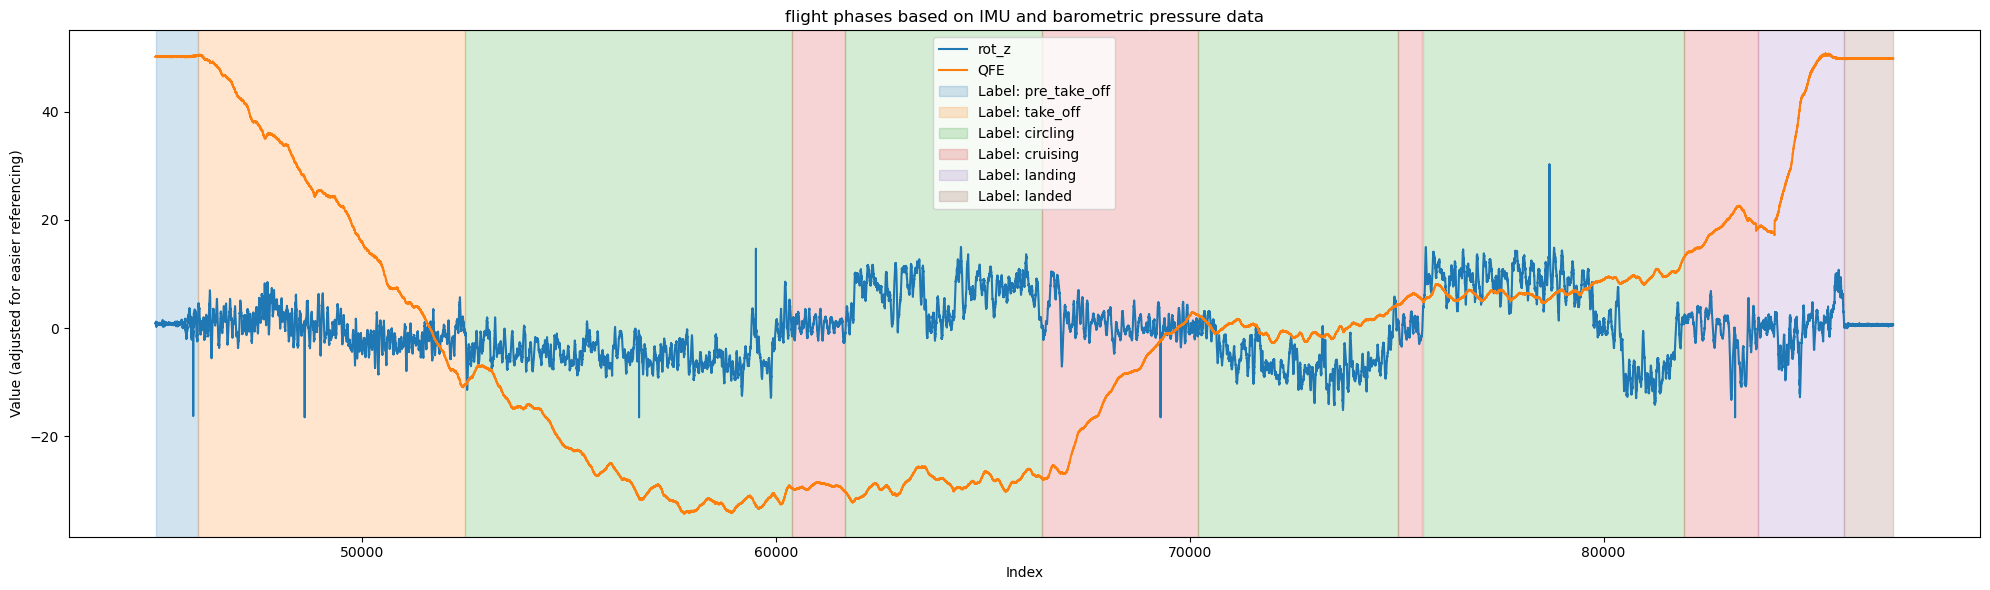

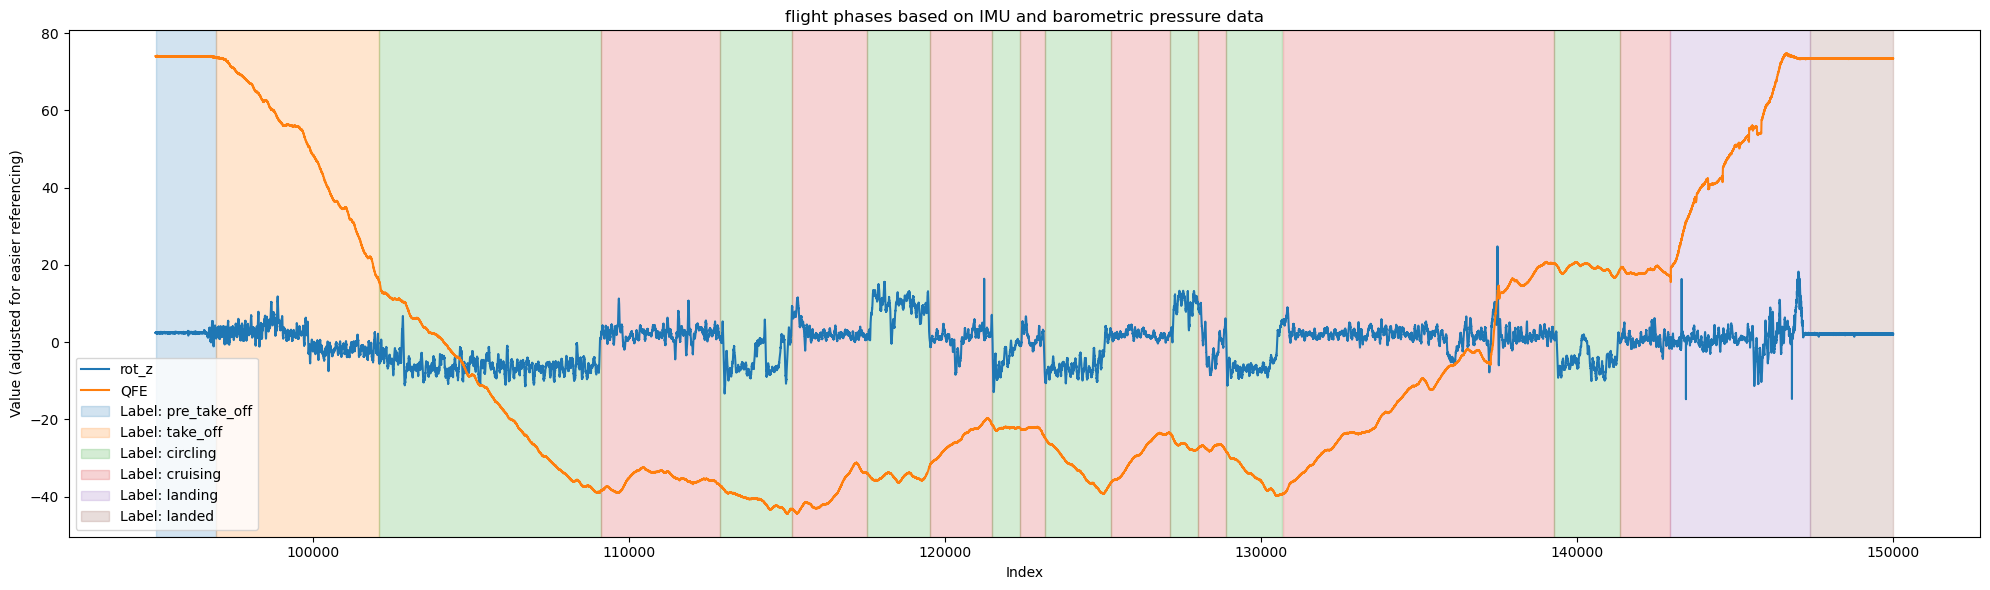

In [5]:
DATA_BASE = "../flight-sample-data/full-data/IMU/"
plot_data(pd.read_csv(DATA_BASE + "flight0.csv")[67000:180000], output_file="flight0.png")
plot_data(pd.read_csv(DATA_BASE + "flight1.csv")[45000:87000],  output_file="flight1.png")
plot_data(pd.read_csv(DATA_BASE + "flight2.csv")[95000:150000], output_file="flight2.png")

## Testing Filters

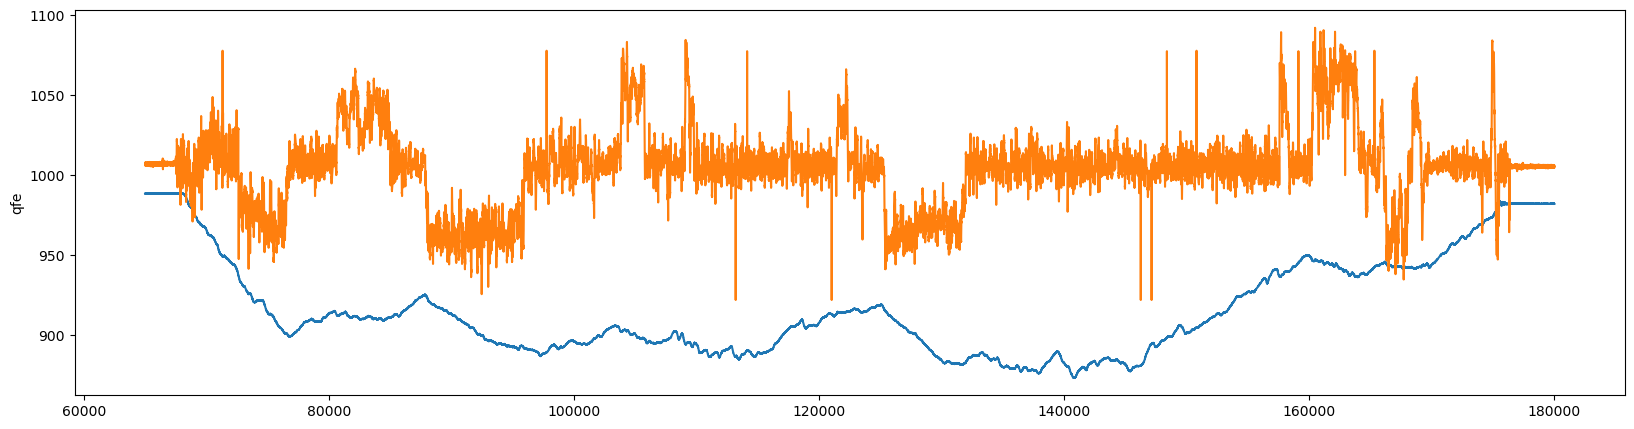

In [6]:
def plot_test(data):
    plt.figure(figsize=(20,5)) 
    plt.plot(data["qfe"][65000:180000])
    plt.plot(data["rot_z"][65000:180000] * 5 + 1000)
    plt.ylabel('qfe')
    plt.show()
plot_test(data)

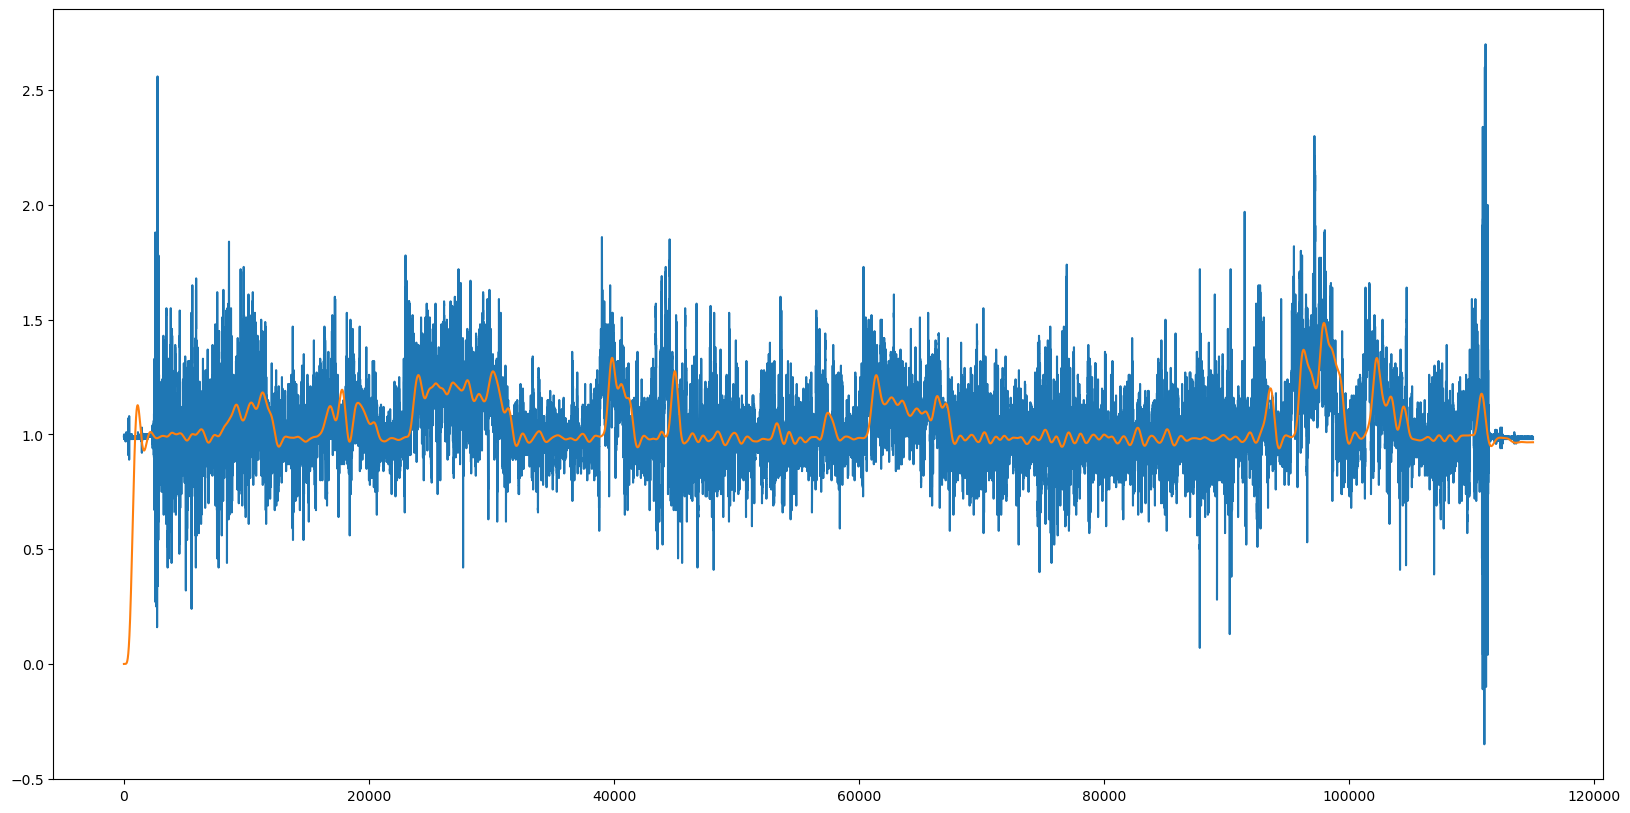

In [7]:
cutoff = 1
fs = 1000
order = 6
rot = np.array(data["acc_z"][65000:180000])
y = butter_lowpass_filter(rot, cutoff, fs, order)

plt.figure(figsize=(20,10)) 
plt.plot(rot)
plt.plot(y)
plt.show()

## Chunking labelled data for Edge Impulse

In [8]:
files = ["flight0", "flight1", "flight2"]
phases = ["pre_take_off", "take_off", "cruising", "circling", "landing", "landed"]

phase_map = {
    "pre_take_off": "grounded",
    "take_off": "cruising",
    "cruising": "cruising",
    "landing": "cruising",
    "circling": "circling",
    "landed": "grounded",
}


In [9]:
def split_dataframe_by_consecutive_groups(df, group_col):
    chunks = []
    current_group = None
    start_idx = 0

    for i, group in enumerate(df[group_col]):
        _group = group
        if _group != current_group:
            if current_group is not None:
                chunks.append(df.iloc[start_idx:i])
            current_group = _group
            start_idx = i

    # Append the last group
    chunks.append(df.iloc[start_idx:])
    return chunks

from collections import defaultdict
def write_chunks_to_csv_by_groupname(chunks, group_col, output_dir='.', original="x", group_map=None):
    group_counts = defaultdict(int)

    for chunk in chunks:
        raw_group = chunk.iloc[0][group_col]
        group_name = group_map[raw_group] if group_map is not None else raw_group
        i = group_counts[group_name]
        filename = f"{output_dir}/{group_name}.{original}-{i}.csv"
        chunk.drop([group_col], axis=1).to_csv(filename, index=False)
        print(f"Wrote {filename}")
        group_counts[group_name] += 1

In [10]:
# NOTE: Make sure you have created all output_dir directories
for f in files:
    df = pd.read_csv(DATA_BASE + "/" + f + ".csv")

    chunks = split_dataframe_by_consecutive_groups(df, 'phase')
    write_chunks_to_csv_by_groupname(chunks, 'phase', output_dir="out", original=f)
    print()
    write_chunks_to_csv_by_groupname(chunks, 'phase', output_dir="out_grouped", group_map=phase_map, original=f)
    print()

Wrote out/pre_take_off.flight0-0.csv
Wrote out/take_off.flight0-0.csv
Wrote out/circling.flight0-0.csv
Wrote out/cruising.flight0-0.csv
Wrote out/circling.flight0-1.csv
Wrote out/cruising.flight0-1.csv
Wrote out/circling.flight0-2.csv
Wrote out/cruising.flight0-2.csv
Wrote out/circling.flight0-3.csv
Wrote out/cruising.flight0-3.csv
Wrote out/circling.flight0-4.csv
Wrote out/cruising.flight0-4.csv
Wrote out/circling.flight0-5.csv
Wrote out/cruising.flight0-5.csv
Wrote out/circling.flight0-6.csv
Wrote out/cruising.flight0-6.csv
Wrote out/circling.flight0-7.csv
Wrote out/cruising.flight0-7.csv
Wrote out/circling.flight0-8.csv
Wrote out/cruising.flight0-8.csv
Wrote out/circling.flight0-9.csv
Wrote out/cruising.flight0-9.csv
Wrote out/landing.flight0-0.csv
Wrote out/landed.flight0-0.csv

Wrote out_grouped/grounded.flight0-0.csv
Wrote out_grouped/cruising.flight0-0.csv
Wrote out_grouped/circling.flight0-0.csv
Wrote out_grouped/cruising.flight0-1.csv
Wrote out_grouped/circling.flight0-1.csv
W